In [1]:
import numpy as np
import pandas as pd
from datetime import datetime

from sklearn.datasets import load_breast_cancer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.model_selection import TimeSeriesSplit

#from matplotlib import pyplot
import matplotlib.pyplot as plt

import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

In [2]:
def read_csv(file):
    df = pd.read_csv(file, parse_dates=True, index_col=0)
    return df

In [3]:
def f1_eval(y_pred, dtrain):
    y_true = dtrain.get_label()
    err = f1_score(y_true, np.round(y_pred))
    return 'f1_err', err

In [4]:
def print_confusion_matrix(tn, fp, fn, tp):
    print("    ","True", "False")
    print("True ", " ", tp, "  ", fp)
    print("False", " ",fn,"  ", tn)
    print("_______________________________________")
    print("---------------------------------------")

In [5]:
def format(val, pos):
    if val == 0:
        return "BULL"
    if val == 1:
        return "BEAR"
    else:
        return ""

In [6]:
def plot(real, imputed):
    fig, ax = plt.subplots(figsize=(20,4))
    ax.xaxis.set_major_locator(plt.MaxNLocator(50))
    ax.plot(real.index, real, '-', label="Real Data", color='blue')
    ax.plot(real.index, imputed, '-', label="Imputed Data", color='red')
    ax.legend(['Real Data', 'Predicted Data'])
    ax.yaxis.set_major_locator(plt.MaxNLocator(3))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(format))
    ax.set_ylim(-0.1, 1.1)
    fig.autofmt_xdate()
    plt.show()

## XGBoost


_______________________________________
______________Training_________________
F1 score 0.9973190348525469
     True False
True    372    2
False   0    408
_______________________________________
---------------------------------------
_______________Testing_________________
F1 score 0.5393258426966292
     True False
True    24    0
False   41    207
_______________________________________
---------------------------------------
---------------------------------------


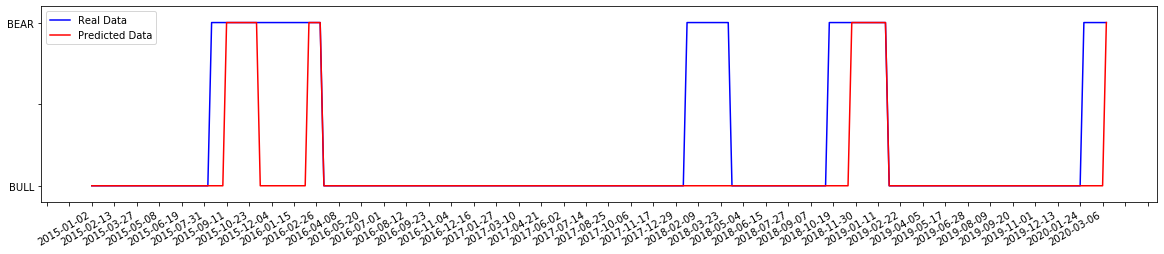

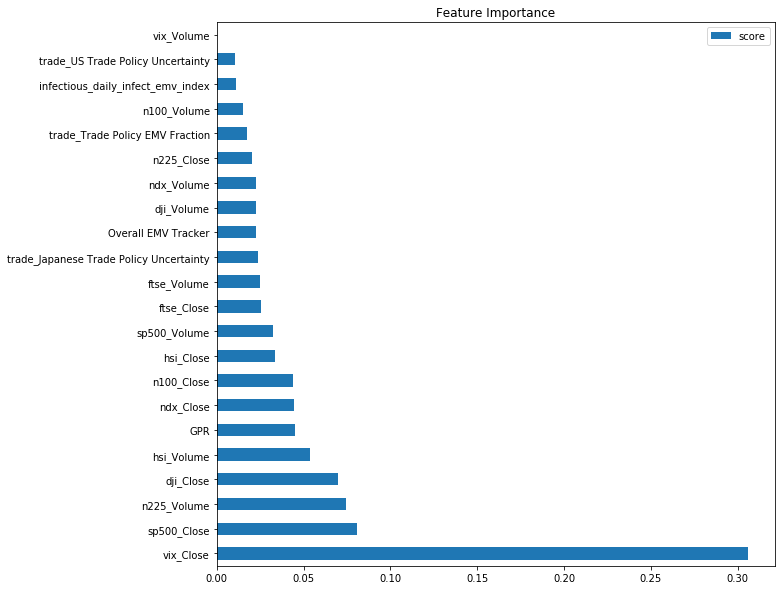

In [7]:
X_train = read_csv('output/\lstm/\CompleteIndexesWeeklyTrainLSTM30_0.csv')
X_test = read_csv('output/\lstm/\/CompleteIndexesWeeklyTestLSTM30_0.csv')
X_train = X_train.reindex(sorted(X_train.columns), axis=1)
X_test = X_test.reindex(sorted(X_test.columns), axis=1)['2015-01-02':'2020-03-13']

y = pd.read_csv('input/\sp500_target_regimes.csv', parse_dates=True)
y.index = y['date'].values
y = y[['regime']]
y = y['regime']=='BEAR'
y = pd.DataFrame (y, columns = ['regime'])

y_train = y.loc['2000-01-01':'2015-01-01']
y_test = y.loc['2015-01-02':'2020-03-13']

best_params = {'colsample_bytree': 0.4, 
               'gamma': 0,
               'learning_rate': 0.1, 
               'max_delta_step': 2,
               'max_depth': 1,
               'min_child_weight': 3,
               'n_estimators': 1800,
               'reg_alpha': 0.1,
               'scale_pos_weight': 80,
               'subsample': 0.7}

xgb_model = xgb.XGBClassifier(objective="binary:logistic",
                                  eval_metric = 'auc',
                                  learning_rate=best_params['learning_rate'], 
                                  n_estimators=best_params['n_estimators'], 
                                  min_child_weight=best_params['min_child_weight'], 
                                  gamma=best_params['gamma'],
                                  max_delta_step=best_params['max_delta_step'],
                                  max_depth=best_params['max_depth'],
                                  subsample=best_params['subsample'],
                                  scale_pos_weight=best_params['scale_pos_weight'],
                                  colsample_bytree=best_params['colsample_bytree'],
                                  reg_alpha=best_params['reg_alpha']
                              )
model = xgb_model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
print("_______________________________________")
print("______________Training_________________")
tn, fp, fn, tp = confusion_matrix(y_train, y_train_pred).ravel()
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f_score = 2*precision*recall/(precision+recall)  
print("F1 score", f_score)
print_confusion_matrix(tn, fp, fn, tp)
print("_______________Testing_________________")
y_pred = model.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f_score = 2*precision*recall/(precision+recall)
print("F1 score", f_score)
print_confusion_matrix(tn, fp, fn, tp)
print("---------------------------------------")

#plot bear bull imputed and real
plot(y_test, y_pred)
# feature importance
data = pd.DataFrame(data=xgb_model.feature_importances_, index=X_train.columns, columns=["score"]).sort_values(by = "score", ascending=False)
data.plot(kind='barh', title="Feature Importance", figsize=(10,10))


In [14]:
def run_experiment_multiple_times(best_params, n=30):
    result_dict = {}
    result_dict= {'f1':0, 'tn':0, 'fp':0, 'fn':0, 'tp':0, 'auc':0, 'best_f1':0, 'best_model':None, 'best_f1':0, 'best_tn':0, 'best_fp':0, 'best_fn':0, 'best_tp':0}
    list_f1 = []


    for i in range(0,n):
        X_train = read_csv('output/\lstm/\CompleteIndexesWeeklyTrainLSTM30_'+str(i)+'.csv')
        X_test = read_csv('output/\lstm/\/CompleteIndexesWeeklyTestLSTM30_'+str(i)+'.csv')
        X_train = X_train.reindex(sorted(X_train.columns), axis=1)
        X_test = X_test.reindex(sorted(X_test.columns), axis=1)['2015-01-02':'2020-03-13']

        y = pd.read_csv('input/\sp500_target_regimes.csv', parse_dates=True)
        y.index = y['date'].values
        y = y[['regime']]
        y = y['regime']=='BEAR'
        y = pd.DataFrame (y, columns = ['regime'])

        y_train = y.loc['2000-01-01':'2015-01-01']
        y_test = y.loc['2015-01-02':'2020-03-13']

        best_params = {'colsample_bytree': 0.4, 
                       'gamma': 0,
                       'learning_rate': 0.1, 
                       'max_delta_step': 2,
                       'max_depth': 1,
                       'min_child_weight': 3,
                       'n_estimators': 1800,
                       'reg_alpha': 0.1,
                       'scale_pos_weight': 80,
                       'subsample': 0.7}

        xgb_model = xgb.XGBClassifier(objective="binary:logistic",
                                          eval_metric = 'auc',
                                          learning_rate=best_params['learning_rate'], 
                                          n_estimators=best_params['n_estimators'], 
                                          min_child_weight=best_params['min_child_weight'], 
                                          gamma=best_params['gamma'],
                                          max_delta_step=best_params['max_delta_step'],
                                          max_depth=best_params['max_depth'],
                                          subsample=best_params['subsample'],
                                          scale_pos_weight=best_params['scale_pos_weight'],
                                          colsample_bytree=best_params['colsample_bytree'],
                                          reg_alpha=best_params['reg_alpha']
                                      )
        model = xgb_model.fit(X_train, y_train)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        precision = tp/(tp+fp)
        recall = tp/(tp+fn)
        f_score = (2*precision*recall/(precision+recall))
        print('Round', i, "f1", f_score)
        list_f1.append(f_score)
        result_dict['f1'] += f_score
        result_dict['tn'] += tn
        result_dict['fp'] += fp
        result_dict['fn'] += fn
        result_dict['tp'] += tp
        if result_dict['best_f1'] < f_score:
            result_dict['best_f1'] = f_score
            result_dict['best_model'] = model
            result_dict['best_tn'] = tn
            result_dict['best_fp'] = fp
            result_dict['best_fn'] = fn
            result_dict['best_tp'] = tp
        

    #plot bear bull imputed and real
    #plot(y_test, y_pred)
    # feature importance
    #data = pd.DataFrame(data=xgb_model.feature_importances_, index=X_train.columns, columns=["score"]).sort_values(by = "score", ascending=False)
    #data.plot(kind='barh', title="Predicted v. Real", figsize=(10,10))
    print("STD f1", np.std(list_f1, axis=0))
    result_dict['f1'] = result_dict['f1']/n
    result_dict['tn'] = result_dict['tn']/n
    result_dict['fp'] = result_dict['fp']/n
    result_dict['fn'] = result_dict['fn']/n
    result_dict['tp'] = result_dict['tp']/n
        
    return result_dict     

In [15]:
result_dict = run_experiment_multiple_times(best_params, n=30)

Round 0 f1 0.5393258426966292
Round 1 f1 0.5393258426966292
Round 2 f1 0.5393258426966292
Round 3 f1 0.5393258426966292
Round 4 f1 0.5393258426966292
Round 5 f1 0.5393258426966292
Round 6 f1 0.5393258426966292
Round 7 f1 0.5393258426966292
Round 8 f1 0.5393258426966292
Round 9 f1 0.5393258426966292
Round 10 f1 0.5393258426966292
Round 11 f1 0.5393258426966292
Round 12 f1 0.5393258426966292
Round 13 f1 0.5393258426966292
Round 14 f1 0.5393258426966292
Round 15 f1 0.5393258426966292
Round 16 f1 0.5393258426966292
Round 17 f1 0.5393258426966292
Round 18 f1 0.5393258426966292
Round 19 f1 0.5393258426966292
Round 20 f1 0.5393258426966292
Round 21 f1 0.5393258426966292
Round 22 f1 0.5393258426966292
Round 23 f1 0.5393258426966292
Round 24 f1 0.5393258426966292
Round 25 f1 0.5393258426966292
Round 26 f1 0.5393258426966292
Round 27 f1 0.5393258426966292
Round 28 f1 0.5393258426966292
Round 29 f1 0.5393258426966292
STD f1 1.1102230246251565e-16


In [16]:
result_dict

{'f1': 0.5393258426966289,
 'tn': 207.0,
 'fp': 0.0,
 'fn': 41.0,
 'tp': 24.0,
 'auc': 0,
 'best_f1': 0.5393258426966292,
 'best_model': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=0.4, eval_metric='auc',
               gamma=0, gpu_id=-1, importance_type='gain',
               interaction_constraints='', learning_rate=0.1, max_delta_step=2,
               max_depth=1, min_child_weight=3, missing=nan,
               monotone_constraints='()', n_estimators=1800, n_jobs=0,
               num_parallel_tree=1, random_state=0, reg_alpha=0.1, reg_lambda=1,
               scale_pos_weight=80, subsample=0.7, tree_method='exact',
               validate_parameters=1, verbosity=None),
 'best_tn': 207,
 'best_fp': 0,
 'best_fn': 41,
 'best_tp': 24}

In [17]:
print("Average F1 Score", result_dict['f1'])
print_confusion_matrix(result_dict['tn'], result_dict['fp'], result_dict['fn'], result_dict['tp'])
print("_______________________________________________________________________________")
print("Best F1 Score", result_dict['best_f1'])
print_confusion_matrix(result_dict['best_tn'], result_dict['best_fp'], result_dict['best_fn'], result_dict['best_tp'])
print("_______________________________________________________________________________")

Average F1 Score 0.5393258426966289
     True False
True    24.0    0.0
False   41.0    207.0
_______________________________________
---------------------------------------
_______________________________________________________________________________
Best F1 Score 0.5393258426966292
     True False
True    24    0
False   41    207
_______________________________________
---------------------------------------
_______________________________________________________________________________
